# Modeling Crop Yield: Landsat + Sentinel
## Python modules

In [1]:
## import warnings
import time
import math
import os
import glob
from pyhere import here
from datetime import date
import re
from collections import Counter

import numpy as np
import pandas as pd
import geopandas
import pickle

import pyarrow
import itertools
import multiprocessing
import p_tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, LeaveOneGroupOut, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score
from scipy.stats import spearmanr,  pearsonr

import task_modeling_utils

In [3]:
files = os.listdir(here("data", "random_features", 'summary'))
files = [f for f in files if f not in ('.gitkeep', '.ipynb_checkpoints')]
files.sort()
### get all combos of files
paramlist = list(itertools.product(files, files))

### get rid of files matched with themselves
paramlist = list(set(tuple(sorted(s)) for s in paramlist))
paramlist = [tuple(set(paramlist[i])) for i in range(len(paramlist))]
paramlist = [x for x in paramlist if len(x) > 1] 

### match all files to both T and F for hot encoding
paramlist = list(itertools.product(paramlist, [True, False]))
for i in range(len(paramlist)):
    paramlist[i] = tuple(merge(paramlist[i]))
    
### Filter files with 20k points and not crop masked (not possible)
pattern1, pattern2  = re.compile("20k-points"), re.compile("cm-False")
paramlist = [t for t in paramlist if not (bool(pattern1.search(t[0])) & bool(pattern2.search(t[0])))]
paramlist = [t for t in paramlist if not (bool(pattern1.search(t[1])) & bool(pattern2.search(t[1])))]
len(paramlist)

1892

In [4]:
# for params in paramlist[0:1]:
def model_2_sensors(params):
#########################################     SET PARAMS    #########################################    
    f1         = params[0]
    f2         = params[1]
    hot_encode = params[2]

    satellite1, bands1, country_code, points1, yrs1, mns1,\
    num_features1, limit_months1, crop_mask1, weighted_avg1 = split_fn(f1)

    satellite2, bands2, country_code, points2, yrs2, mns2,\
    num_features2, limit_months2, crop_mask2, weighted_avg2 = split_fn(f2)

#########################################     READ DATA    #########################################
    features_1 = pd.read_feather(here('data', 'random_features', 'summary', f1))
    features_2 = pd.read_feather(here('data', 'random_features', 'summary', f2))
    climate_df = pd.read_csv(here('data', 'climate', 'climate_summary.csv'))

#########################################     CLEAN DATA    #########################################  
    min_year = max(min(features_1.year), min(features_2.year))
    max_year = min(max(features_1.year), max(features_2.year))

    features_1 = features_1[features_1.year >= min_year]
    features_2 = features_2[features_2.year >= min_year]

    features_1 = features_1[features_1.year <= max_year]
    features_2 = features_2[features_2.year <= max_year]

    features_1.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)
    features_2.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)

#########################################     JOIN FEATURES    #########################################  
    drop_cols = ['district', 'year', 'yield_mt']

    features_1 = features_1.set_index(drop_cols).add_prefix("f1_")
    features_2 = features_2.set_index(drop_cols).add_prefix("f2_")

    features = features_1.join(features_2).reset_index()
    features = features[~features.isna().any(axis = 1)]

#########################################    JOIN CLIMATE VARS    ######################################### 
    ndvi_cols = climate_df.columns[climate_df.columns.to_series().str.contains('ndvi')]
    keep_cols = [*ndvi_cols, *drop_cols]
    climate_df = climate_df.loc[:, keep_cols]

    features = features.set_index(drop_cols).join(climate_df.set_index(drop_cols)).reset_index()
    features = features[features.year <= max(climate_df.year)]

    crop_yield = features.copy().loc[:, tuple(drop_cols)]
    crop_yield["log_yield"] = np.log10(crop_yield.yield_mt.to_numpy() + 1)

#########################################    HOT ENCODE    ######################################### 
    if hot_encode:
        drop_cols.remove('district')
        features = pd.get_dummies(features, columns = ["district"], drop_first = False)
    else:
        pass

#########################################    STANDARDIZE FEATURES    #########################################    
    features = features.set_index(drop_cols) 
    features_scaled = StandardScaler().fit_transform(features.values)
    features = pd.DataFrame(features_scaled, index=features.index).reset_index()
    features.columns = features.columns.astype(str)

#########################################     K-FOLD SPLIT    #########################################
    x_all = features.drop(drop_cols, axis = 1) 
    y_all = np.log10(features.yield_mt.to_numpy() + 1)
    x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

#########################################     K-FOLD CV   ###########################################
    ### SETUP
    alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
    kfold = KFold()
    ridge = Ridge()    
    ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
    ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
    ridge_reg.fit(x_train, y_train)
    best_model = ridge_reg.best_estimator_
    ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
    val_predictions = cross_val_predict(best_model, X = x_train, y = y_train, cv = kfold)   
    train_predictions = best_model.predict(x_train)
    test_predictions  = best_model.predict(x_test)

#########################################     DE-MEAN R2    #########################################    
    crop_yield["prediction"] = np.maximum(best_model.predict(x_all), 0)

    train_split = pd.DataFrame(np.repeat('train', len(x_train)), columns = ['split'], index = x_train.index)
    train_split = train_split.join(crop_yield.copy()[crop_yield.index.isin(x_train.index)])
    train_split['cv_prediction'] = np.maximum(val_predictions, 0)
    train_split["demean_cv_yield"] = train_split["log_yield"]-train_split.groupby('district')['log_yield'].transform('mean')
    train_split["demean_cv_prediction"] = train_split["cv_prediction"]-train_split.groupby('district')['cv_prediction'].transform('mean')

    test_split = pd.DataFrame(np.repeat('test', len(x_test)), columns = ['split'], index = x_test.index)
    test_split = test_split.join(crop_yield.copy()[crop_yield.index.isin(x_test.index)])
    test_split['cv_prediction'] = np.repeat(np.nan, len(x_test))
    test_split["demean_cv_yield"] = np.repeat(np.nan, len(x_test))
    test_split["demean_cv_prediction"] = np.repeat(np.nan, len(x_test))

    predictions = pd.concat([train_split, test_split])

#########################################     SAVE MODELS   #########################################  
    # fn_1 = f'{satellite1[0]}_{bands1}_{points1}_{limit_months1}_{crop_mask1}_{weighted_avg1}'
    # fn_2 = f'{satellite2[0]}_{bands2}_{points2}_{limit_months2}_{crop_mask2}_{weighted_avg2}'
    # model_fn_suffix = f'fn-1_{fn_1}_fn-2_{fn_2}'
    # k_model_fn = f'kfold-cv_rr-model_{model_fn_suffix}_he-{hot_encode}.pkl'

    # with open(here('models', k_model_fn),'wb') as f:
    #     pickle.dump(best_model, f)

#########################################     SAVE RESULTS    #########################################
    d = {
        'country': country_code,

        'satellite_1'   : satellite1[0],
        'bands_1'       : bands1,
        'num_features_1': num_features1,
        'points_1'      : points1, 
        'month_range_1' : mns1,
        'limit_months_1': limit_months1,
        'crop_mask_1'   : crop_mask1,
        'weighted_avg_1': weighted_avg1,

        'satellite_2'   : satellite2[0],
        'bands_2'       : bands2,
        'num_features_2': num_features2,
        'points_2'      : points2, 
        'month_range_2' : mns2,
        'limit_months_2': limit_months2,
        'crop_mask_2'   : crop_mask2,
        'weighted_avg_2': weighted_avg2,

        'hot_encode': hot_encode,

        'total_n': len(x_all),
        'train_n': len(x_train),
        'test_n' : len(x_test),

        'best_reg_param': list(ridge_reg.best_params_.values())[0],
        'mean_of_val_R2': ridge_reg.best_score_,
        'val_R2': r2_score(y_train, val_predictions),
        'val_r' : pearsonr(val_predictions, y_train)[0],
        'val_r2': pearsonr(val_predictions, y_train)[0] ** 2,

        'train_R2': r2_score(y_train, train_predictions),
        'train_r' : pearsonr(train_predictions, y_train)[0],
        'train_r2': pearsonr(train_predictions, y_train)[0] ** 2,

        'test_R2': r2_score(y_test, test_predictions),
        'test_r' : pearsonr(test_predictions, y_test)[0],
        'test_r2': pearsonr(test_predictions, y_test)[0] ** 2,

        'demean_cv_R2': r2_score(train_split.demean_cv_yield, train_split.demean_cv_prediction),
        'demean_cv_r':  pearsonr(train_split.demean_cv_yield, train_split.demean_cv_prediction)[0],
        'demean_cv_r2': pearsonr(train_split.demean_cv_yield, train_split.demean_cv_prediction)[0] ** 2,
    }
    df = pd.DataFrame(data=d)
    return df

In [5]:
# %%time     
# ##### With progress bar
# workers = os.cpu_count()
# if __name__ == "__main__":
#     output = []
#     for result in p_tqdm.p_map(model_2_sensors, paramlist):
#         output.append(result)
#     results = pd.concat(output).reset_index(drop=True)
#     today = date.today().strftime("%Y-%m-%d")
#     file_name = f'2_sensor_results_{today}.csv'
#     print(f"Saving results as: {file_name}\n\n")           
#     results.to_csv(here("data","results", file_name), index=False)

In [6]:
## TESTING  
f1 = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-False_wa-False_summary.feather'
f2 = 'sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_yr-2016-2022_mn-1-12_lm-False_cm-True_wa-False_summary.feather'
hot_encode = True

#########################################     SET PARAMS    #########################################    
# f1         = params[0]
# f2         = params[1]
# hot_encode = params[2]

satellite1, bands1, country_code, points1, yrs1, mns1,\
num_features1, limit_months1, crop_mask1, weighted_avg1 = split_fn(f1)

satellite2, bands2, country_code, points2, yrs2, mns2,\
num_features2, limit_months2, crop_mask2, weighted_avg2 = split_fn(f2)

#########################################     READ DATA    #########################################
features_1 = pd.read_feather(here('data', 'random_features', 'summary', f1))
features_2 = pd.read_feather(here('data', 'random_features', 'summary', f2))
climate_df = pd.read_csv(here('data', 'climate', 'climate_summary.csv'))

#########################################     CLEAN DATA    #########################################  
min_year = max(min(features_1.year), min(features_2.year))
max_year = min(max(features_1.year), max(features_2.year))

features_1 = features_1[features_1.year >= min_year]
features_2 = features_2[features_2.year >= min_year]

features_1 = features_1[features_1.year <= max_year]
features_2 = features_2[features_2.year <= max_year]

features_1.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)
features_2.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)

#########################################     JOIN FEATURES    #########################################  
drop_cols = ['district', 'year', 'yield_mt']

features_1 = features_1.set_index(drop_cols).add_prefix("f1_")
features_2 = features_2.set_index(drop_cols).add_prefix("f2_")

features = features_1.join(features_2).reset_index()
features = features[~features.isna().any(axis = 1)]

#########################################    JOIN CLIMATE VARS    ######################################### 
ndvi_cols = climate_df.columns[climate_df.columns.to_series().str.contains('ndvi')]
keep_cols = [*ndvi_cols, *drop_cols]
# climate_df = climate_df.loc[:, keep_cols]

features = features.set_index(drop_cols).join(climate_df.set_index(drop_cols)).reset_index()
features = features[features.year <= max(climate_df.year)]

crop_yield = features.copy().loc[:, tuple(drop_cols)]
crop_yield["log_yield"] = np.log10(crop_yield.yield_mt.to_numpy() + 1)

#########################################    STANDARDIZE FEATURES    #########################################    
features = features.set_index(drop_cols) 
features_scaled = StandardScaler().fit_transform(features.values)
features = pd.DataFrame(features_scaled, index=features.index).reset_index()
features.columns = features.columns.astype(str)

#########################################    HOT ENCODE    ######################################### 
if hot_encode:
    drop_cols.remove('district')
    features = pd.get_dummies(features, columns = ["district"], drop_first = False)
else:
    pass

#########################################     K-FOLD SPLIT    #########################################
x_all = features.drop(drop_cols, axis = 1) 
y_all = np.log10(features.yield_mt.to_numpy() + 1)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

In [ ]:
kfold = KFold(n_splits=5)

In [ ]:
%%time
best_lam, res, model = kfold_rr_multi_lambda_tuning(
    x_train, y_train, 
    grid=np.logspace(-8, 8, base = 10, num = 17), 
    start=[0, x_train.shape[1]-72],
    end=[x_train.shape[1]-72, x_train.shape[1]], 
    static_lam=1e-16, 
    verbose=True, 
    fit_model_after_tuning=True
)
val_predictions = cross_val_predict(model, X = x_train, y = y_train, cv = kfold) 
print(f"""Final Val R2: {r2_score(y_train, val_predictions):0.4f}
Final Test R2: {r2_score(y_test, model.predict(x_test)):0.4f}""")

In [9]:
# from prediction_utils import *
from prediction_utils_1 import *

In [10]:
solver_kwargs = {
    # set of possible hyperparameters to search over in cross-validation
    "lambdas": np.logspace(-8, 8, base = 10, num = 17), # [1e-3,1e-2, 1e-1, 1e0,1e1,1e2,1e3,1e4,1e5,1e6],
    # do you want to return the predictions from the model?
    "return_preds": True,
    # input the bounds used to clip predictions
    "return_model": False,
    # do you want to use an SVD solve or standard linear regression? (NB: SVD is much slower)
    "svd_solve": False,
    # do you want to allow hyperparameters to be chosen even if they lead to warnings about matrix invertibility?
    "allow_linalg_warning_instances": True,
    
    "fit_model_after_tuning": False,
    'static_lam_val': 1e-18,
    'static_lam_idxs': list(range(x_train.shape[1]-72, x_train.shape[1])),
    # "static_lam_idxs": list(range(0,x_train.shape[1]-72)),
    "intercept": True
}

In [11]:
%%time
kfold_results = kfold_solve_custom_split_col(
    X=x_train,
    y=y_train,
    locations=x_train.index,
    split_col=x_train.reset_index().index,
    num_folds=5,
    random_state=0,
    **solver_kwargs
)
best_alpha_1_idx = interpret_kfold_results(kfold_results, "r2_score")[0][0][0]
best_alpha_1 = list(solver_kwargs.get('lambdas'))[best_alpha_1_idx]
preds = np.maximum(get_pred_truth_locs(kfold_results)[0].flatten(), 0)
truth = get_pred_truth_locs(kfold_results)[1].flatten()
locations = get_pred_truth_locs(kfold_results)[2].flatten()
print(
f"""Best alpha: {best_alpha_1}
Val R2: {r2_score(truth, preds)}"""
)

on fold (of 5): 0 linalg warning on lambda=1e-08: 
we will allow this model upon model selection
linalg warning on lambda=1e-07: 
we will allow this model upon model selection
linalg warning on lambda=1e-06: 
we will allow this model upon model selection
linalg warning on lambda=1e-05: 
we will allow this model upon model selection
linalg warning on lambda=0.0001: 
we will allow this model upon model selection
linalg warning on lambda=0.001: 
we will allow this model upon model selection
linalg warning on lambda=0.01: 
we will allow this model upon model selection
linalg warning on lambda=0.1: 
we will allow this model upon model selection
linalg warning on lambda=1.0: 
we will allow this model upon model selection
linalg warning on lambda=10.0: 
we will allow this model upon model selection
linalg warning on lambda=100.0: 
we will allow this model upon model selection
linalg warning on lambda=1000.0: 
we will allow this model upon model selection
linalg warning on lambda=10000.0: 
we 

C:\Users\Cullen\anaconda3\envs\mosaiks-env\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [12]:
solver_kwargs = {
    # set of possible hyperparameters to search over in cross-validation
    "lambdas": np.logspace(-7, 7, base = 10, num = 15), # [1e-3,1e-2, 1e-1, 1e0,1e1,1e2,1e3,1e4,1e5,1e6],
    # do you want to return the predictions from the model?
    "return_preds": True,
    # input the bounds used to clip predictions
    "return_model": False,
    # do you want to use an SVD solve or standard linear regression? (NB: SVD is much slower)
    "svd_solve": False,
    # do you want to allow hyperparameters to be chosen even if they lead to warnings about matrix invertibility?
    "allow_linalg_warning_instances": True,
    "fit_model_after_tuning": False,
    "static_lam_val": best_alpha_1,
    # 'static_lam_idxs': list(range(x_train.shape[1]-72, x_train.shape[1])),
    "static_lam_idxs": list(range(0, x_train.shape[1]-72)),
    "intercept": True
}

In [13]:
%%time
kfold_results = kfold_solve_custom_split_col(
    X=x_train,
    y=y_train,
    locations=x_train.index,
    split_col=x_train.reset_index().index,
    num_folds=5,
    random_state=1991,
    **solver_kwargs
)
best_alpha_2_idx = interpret_kfold_results(kfold_results, "r2_score")[0][0][0]
best_alpha_2 = list(solver_kwargs.get('lambdas'))[best_alpha_2_idx]
preds = np.maximum(get_pred_truth_locs(kfold_results)[0].flatten(), 0)
truth = get_pred_truth_locs(kfold_results)[1].flatten()
locations = get_pred_truth_locs(kfold_results)[2].flatten()
print(
f"""Best alpha: {best_alpha_2}
Val R2: {r2_score(truth, preds)}"""
)

on fold (of 5): 0 1 2 3 4 

Best alpha: 0.1
Val R2: 0.8053374587668608
CPU times: total: 2h 10min 1s
Wall time: 34min 49s


C:\Users\Cullen\anaconda3\envs\mosaiks-env\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


holdout r2: 0.805
holdout Pearson R: 0.898




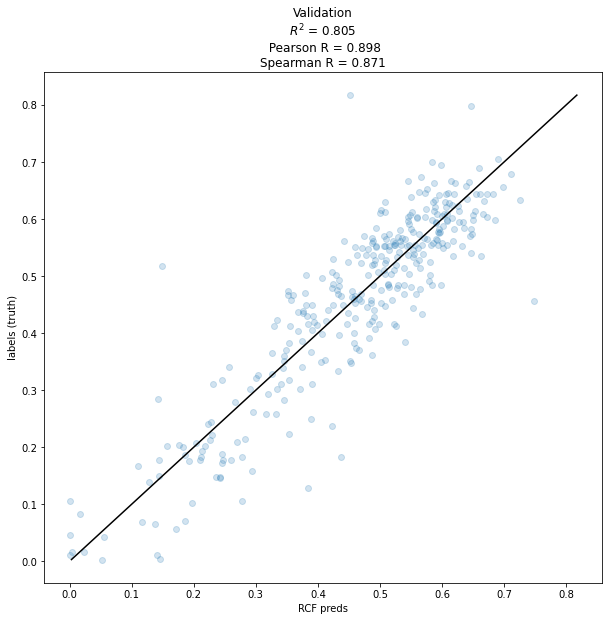

In [14]:
make_train_pred_scatterplot(task = "Validation", y_test = truth, preds_test = preds)

In [15]:
# best_alpha_2_idx

In [16]:
# kfold_results.get('models')[0][0][best_alpha_2_idx][-1]

In [17]:
model, intercept_term = custom_ridge(
    X=x_train,
    y=y_train,
    lam=best_alpha_1, 
    intercept=True,
    static_lam_val = best_alpha_2,
    static_lam_idxs =list(range(x_train.shape[1]-72, x_train.shape[1])))

In [18]:
pred_test = np.asarray(x_test).dot(model) + intercept_term 
pred_test = np.maximum(pred_test, 0)
# pred_test

In [19]:
r2_score(y_test, pred_test)

0.7591059790714824

In [20]:
%%time
## TESTING  
f1 = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-False_wa-False_summary.feather'
f2 = 'sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_yr-2016-2022_mn-1-12_lm-False_cm-True_wa-False_summary.feather'
hot_encode = True

#########################################     SET PARAMS    #########################################    
# f1         = params[0]
# f2         = params[1]
# hot_encode = params[2]

satellite1, bands1, country_code, points1, yrs1, mns1,\
num_features1, limit_months1, crop_mask1, weighted_avg1 = split_fn(f1)

satellite2, bands2, country_code, points2, yrs2, mns2,\
num_features2, limit_months2, crop_mask2, weighted_avg2 = split_fn(f2)

#########################################     READ DATA    #########################################
features_1 = pd.read_feather(here('data', 'random_features', 'summary', f1))
features_2 = pd.read_feather(here('data', 'random_features', 'summary', f2))
climate_df = pd.read_csv(here('data', 'climate', 'climate_summary.csv'))

#########################################     CLEAN DATA    #########################################  
min_year = max(min(features_1.year), min(features_2.year))
max_year = min(max(features_1.year), max(features_2.year))

features_1 = features_1[features_1.year >= min_year]
features_2 = features_2[features_2.year >= min_year]

features_1 = features_1[features_1.year <= max_year]
features_2 = features_2[features_2.year <= max_year]

features_1.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)
features_2.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)

#########################################     JOIN FEATURES    #########################################  
drop_cols = ['district', 'year', 'yield_mt']

features_1 = features_1.set_index(drop_cols).add_prefix("f1_")
features_2 = features_2.set_index(drop_cols).add_prefix("f2_")

features = features_1.join(features_2).reset_index()
features = features[~features.isna().any(axis = 1)]

#########################################    JOIN CLIMATE VARS    ######################################### 
ndvi_cols = climate_df.columns[climate_df.columns.to_series().str.contains('ndvi')]
keep_cols = [*ndvi_cols, *drop_cols]
# climate_df = climate_df.loc[:, keep_cols]

features = features.set_index(drop_cols).join(climate_df.set_index(drop_cols)).reset_index()
features = features[features.year <= max(climate_df.year)]

crop_yield = features.copy().loc[:, tuple(drop_cols)]
crop_yield["log_yield"] = np.log10(crop_yield.yield_mt.to_numpy() + 1)

#########################################    HOT ENCODE    ######################################### 
if hot_encode:
    drop_cols.remove('district')
    features = pd.get_dummies(features, columns = ["district"], drop_first = False)
else:
    pass

#########################################    STANDARDIZE FEATURES    #########################################    
features = features.set_index(drop_cols) 
features_scaled = StandardScaler().fit_transform(features.values)
features = pd.DataFrame(features_scaled, index=features.index).reset_index()
features.columns = features.columns.astype(str)

#########################################     K-FOLD SPLIT    #########################################
x_all = features.drop(drop_cols, axis = 1) 
y_all = np.log10(features.yield_mt.to_numpy() + 1)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

#########################################     K-FOLD CV   ###########################################
### SETUP
alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
kfold = KFold()
ridge = Ridge()    
### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
ridge_reg.fit(x_train, y_train)
best_model = ridge_reg.best_estimator_
### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
val_predictions = cross_val_predict(best_model, X = x_train, y = y_train, cv = kfold)   
train_predictions = best_model.predict(x_train)
test_predictions  = best_model.predict(x_test)

#########################################     DE-MEAN R2    #########################################    
crop_yield["prediction"] = np.maximum(best_model.predict(x_all), 0)

train_split = pd.DataFrame(np.repeat('train', len(x_train)), columns = ['split'], index = x_train.index)
train_split = train_split.join(crop_yield.copy()[crop_yield.index.isin(x_train.index)])
train_split['cv_prediction'] = np.maximum(val_predictions, 0)
train_split["demean_cv_yield"] = train_split["log_yield"]-train_split.groupby('district')['log_yield'].transform('mean')
train_split["demean_cv_prediction"] = train_split["cv_prediction"]-train_split.groupby('district')['cv_prediction'].transform('mean')

test_split = pd.DataFrame(np.repeat('test', len(x_test)), columns = ['split'], index = x_test.index)
test_split = test_split.join(crop_yield.copy()[crop_yield.index.isin(x_test.index)])
test_split['cv_prediction'] = np.repeat(np.nan, len(x_test))
test_split["demean_cv_yield"] = np.repeat(np.nan, len(x_test))
test_split["demean_cv_prediction"] = np.repeat(np.nan, len(x_test))

predictions = pd.concat([train_split, test_split])

#########################################     SAVE MODELS   #########################################  
# fn_1 = f'{satellite1[0]}_{bands1}_{points1}_{limit_months1}_{crop_mask1}_{weighted_avg1}'
# fn_2 = f'{satellite2[0]}_{bands2}_{points2}_{limit_months2}_{crop_mask2}_{weighted_avg2}'
# model_fn_suffix = f'fn-1_{fn_1}_fn-2_{fn_2}'
# k_model_fn = f'kfold-cv_rr-model_{model_fn_suffix}_he-{hot_encode}.pkl'

# with open(here('models', k_model_fn),'wb') as f:
#     pickle.dump(best_model, f)

#########################################     SAVE RESULTS    #########################################
d = {
    'country': country_code,

    'satellite_1'   : satellite1[0],
    'bands_1'       : bands1,
    'num_features_1': num_features1,
    'points_1'      : points1, 
    'month_range_1' : mns1,
    'limit_months_1': limit_months1,
    'crop_mask_1'   : crop_mask1,
    'weighted_avg_1': weighted_avg1,

    'satellite_2'   : satellite2[0],
    'bands_2'       : bands2,
    'num_features_2': num_features2,
    'points_2'      : points2, 
    'month_range_2' : mns2,
    'limit_months_2': limit_months2,
    'crop_mask_2'   : crop_mask2,
    'weighted_avg_2': weighted_avg2,

    'hot_encode': hot_encode,

    'total_n': len(x_all),
    'train_n': len(x_train),
    'test_n' : len(x_test),

    'best_reg_param': list(ridge_reg.best_params_.values())[0],
    'mean_of_val_R2': ridge_reg.best_score_,
    'val_R2': r2_score(y_train, val_predictions),
    'val_r' : pearsonr(val_predictions, y_train)[0],
    'val_r2': pearsonr(val_predictions, y_train)[0] ** 2,

    'train_R2': r2_score(y_train, train_predictions),
    'train_r' : pearsonr(train_predictions, y_train)[0],
    'train_r2': pearsonr(train_predictions, y_train)[0] ** 2,

    'test_R2': r2_score(y_test, test_predictions),
    'test_r' : pearsonr(test_predictions, y_test)[0],
    'test_r2': pearsonr(test_predictions, y_test)[0] ** 2,

    'demean_cv_R2': r2_score(train_split.demean_cv_yield, train_split.demean_cv_prediction),
    'demean_cv_r':  pearsonr(train_split.demean_cv_yield, train_split.demean_cv_prediction)[0],
    'demean_cv_r2': pearsonr(train_split.demean_cv_yield, train_split.demean_cv_prediction)[0] ** 2,
}
df = pd.DataFrame(data=d)

CPU times: total: 4min 26s
Wall time: 37.1 s


In [21]:
test_split["demean_test_yield"] = test_split["log_yield"]-test_split.groupby('district')['log_yield'].transform('mean')
test_split["demean_test_prediction"] = test_split["prediction"]-test_split.groupby('district')['prediction'].transform('mean')

In [22]:
print(f'Val  R2: {r2_score(y_train, val_predictions):0.4f}',
      f'\nTest R2: {r2_score(y_test, test_predictions):0.4f}',
     f'\n\nDemean Val  R2: {r2_score(train_split.demean_cv_yield, train_split.demean_cv_prediction):0.4f}',
     f'\nDemean Test R2: {r2_score(test_split.demean_test_yield, test_split.demean_test_prediction):0.4f}')

Val  R2: 0.7563 
Test R2: 0.6467 

Demean Val  R2: 0.1603 
Demean Test R2: 0.3323


In [23]:
# fn_1 = f'{satellite1[0]}_{bands1}_{points1}_{limit_months1}_{crop_mask1}_{weighted_avg1}'
# fn_2 = f'{satellite2[0]}_{bands2}_{points2}_{limit_months2}_{crop_mask2}_{weighted_avg2}'
# suffix = f'fn-1_{fn_1}_fn-2_{fn_2}'
# fn = f'predictions_{suffix}_he-{hot_encode}.csv'
    
# predictions_fn = here('data', 'results', fn)
# predictions.to_csv(predictions_fn, index=False)